In [1]:
# !/usr/bin/env python
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #
# xxxxxxxxxxxxxxxxxxxx------------FIT GAUSSIAN PROFILES TO SUPERNOVA SPECTRA----------------xxxxxxxxxxxxxxxxxxxxxxxxx #
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #

# ------------------------------------------------------------------------------------------------------------------- #
# Import Required Libraries
# ------------------------------------------------------------------------------------------------------------------- #
import sys
import numpy as np
import pandas as pd
import uncertainties as unc
from astropy.io import fits
import uncertainties.unumpy as unp
from scipy.optimize import curve_fit, fsolve

import matplotlib.pyplot as plt
from matplotlib import container
from matplotlib.ticker import MultipleLocator
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Global Variables
# ------------------------------------------------------------------------------------------------------------------- #
# Constants
light_speed = 2.99792458e5
norm_factor = 1e-15
parsec = 3.086e18
ev = 1.602e-12
kB = 1.38e-16

# Supernova
dist = 16.45e6
mni = 0.033

# File and Directory path
file_name = 'rrfz_2021-02-21_2020jfo.dat'
DIR_SPEC = '/home/avinash/Supernovae_Data/2020jfo/Spectroscopy/DOT/'
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Plot Confidence Intervals
# Function For Setting Plot Parameters And Plotting
# ------------------------------------------------------------------------------------------------------------------- #

def plot_confintervals(ax_obj, optpar, covpar, xarr, fcolor='orange', components=5):
    """
    Plots 3-Sigma Confidence Intervals in Fits of SN Parameters.
    Args:
        ax_obj     : Axes object on which the confidence interval is to be plotted
        optpar     : Optimised Parameters of the Fit
        covpar     : Covariance Parameters of the Fit
        xarr       : Array of X-Values over which confidence intervals are to be plotted
        fcolor     : Fill color for the confidence intervals
        components : Number of gaussian components in the fit
    Returns:
        None
    """
    def err(xarr, h, c, w):
        return h * unp.exp(-(xarr - c) ** 2 / (2 * w ** 2))

    if components == 2:
        h1, c1, h2, c2, w1, offset = unc.correlated_values(optpar, covpar)
        func = err(xarr, h1, c1, w1) + err(xarr, h2, c2, w1) + offset
    elif components == 3:
        h1, c1, h2, c2, h3, c3, w1, offset = unc.correlated_values(optpar, covpar)
        func = err(xarr, h1, c1, w1) + err(xarr, h2, c2, w1) + err(xarr, h3, c3, w1) + offset
    elif components == 5:
        h1, c1, h2, c2, h3, c3, h4, c4, h5, c5, w1, offset = unc.correlated_values(optpar, covpar)
        func = err(xarr, h1, c1, w1) + err(xarr, h2, c2, w1) + err(xarr, h3, c3, w1) + \
               err(xarr, h4, c4, w1) + err(xarr, h5, c5, w1) + offset
    elif components == 'OIDual':
        h1, c1, h2, c2, h3, h4, h5, c5, z, w1, offset = unc.correlated_values(optpar, covpar)
        func = err(xarr, h1, c1, w1) + err(xarr, h2, c2, w1) + err(xarr, h3, c1 * (1 + z), w1) + \
               err(xarr, h4, c2 * (1 + z), w1) + err(xarr, h5, c5, w1) + offset
    elif components == 'OIDualV2':
        h1, c1, h2, c2, h3, h4, w2, h5, c5, z, w1, offset = unc.correlated_values(optpar, covpar)
        func = err(xarr, h1, c1, w1) + err(xarr, h2, c2, w1) + err(xarr, h3, c1 * (1 + z), w2) + \
               err(xarr, h4, c2 * (1 + z), w2) + err(xarr, h5, c5, w1) + offset
    elif components == 'HalphaDual':
        h1, c1, h2, h3, c3, z, w1, offset = unc.correlated_values(optpar, covpar)
        func = err(xarr, h1, c1, w1) + err(xarr, h2, c1 * (1 + z), w1) + err(xarr, h3, c3, w1) + offset
    elif components == 8:
        h1, c1, h2, c2, h3, c3, h4, c4, h5, c5, h6, c6, h7, c7, h8, c8, w1, offset = unc.correlated_values(optpar, covpar)
        func = err(xarr, h1, c1, w1) + err(xarr, h2, c2, w1) + err(xarr, h3, c3, w1) + \
               err(xarr, h4, c4, w1) + err(xarr, h5, c5, w1) + err(xarr, h6, c6, w1) + \
               err(xarr, h7, c7, w1) + err(xarr, h8, c8, w1) + offset
    elif components == 9:
        h1, c1, h2, c2, h3, c3, h4, c4, h5, c5, h6, c6, h7, c7, h8, c8, h9, c9, w1, offset = unc.correlated_values(optpar, covpar)
        func = err(xarr, h1, c1, w1) + err(xarr, h2, c2, w1) + err(xarr, h3, c3, w1) + \
               err(xarr, h4, c4, w1) + err(xarr, h5, c5, w1) + err(xarr, h6, c6, w1) + \
               err(xarr, h7, c7, w1) + err(xarr, h8, c8, w1) + err(xarr, h9, c9, w1) + offset
        
    fit = unp.nominal_values(func)
    sigma = unp.std_devs(func)

    fitlow = fit - 3 * sigma
    fithigh = fit + 3 * sigma

    ax_obj.plot(xarr, fitlow, ls='-.', c='k', lw=0.7, alpha=0.7, label='_nolegend_')
    ax_obj.plot(xarr, fithigh, ls='-.', c='k', lw=0.7, alpha=0.7, label='_nolegend_')
    ax_obj.fill_between(xarr, fitlow, fithigh, facecolor=fcolor, alpha=0.4)


def set_plotparams(ax_obj, xticks=(50, 5), yticks=(1, 0.1), grid=True, legend=False, fs=14, ms=1.5):
    """
    Sets plot parameters to the axes object 'ax_obj'.
    Args:
        ax_obj      : Axes object to be used for plotting and setting plot parameters
        xticks      : X-Axis Major and Minor tick intervals
        yticks      : Y-Axis Major and Minor tick intervals
        grid        : Boolean stating whether to enable Grid in the plot
        legend      : Boolean stating whether legend is to be displayed in the plot
        fs          : Font of the labels in the legend
        ms          : Scaled marker size to be used in the legend
    Returns:
    """
    if legend:
        handles, labels = ax_obj.get_legend_handles_labels()
        handles = [h[0] if isinstance(h, container.ErrorbarContainer) else h for h in handles]
        ax_obj.legend(handles, labels, fontsize=fs, markerscale=ms, frameon=False)

    if grid:
        ax_obj.grid(True, which='major', ls='--', lw=1, alpha=0.7)

    ax_obj.xaxis.set_ticks_position('both')
    ax_obj.yaxis.set_ticks_position('both')
    ax_obj.xaxis.set_major_locator(MultipleLocator(xticks[0]))
    ax_obj.xaxis.set_minor_locator(MultipleLocator(xticks[1]))
    ax_obj.yaxis.set_major_locator(MultipleLocator(yticks[0]))
    ax_obj.yaxis.set_minor_locator(MultipleLocator(yticks[1]))
    ax_obj.tick_params(axis='both', which='major', direction='in', width=1.6, length=9, color='k', 
                       labelcolor='k', labelsize=fs)
    ax_obj.tick_params(axis='both', which='minor', direction='in', width=1.0, length=5, color='k', 
                       labelcolor='k', labelsize=fs)

# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Mathematical Functions used in Fitting
# ------------------------------------------------------------------------------------------------------------------- #

def gaussian(x, height, center, width, offset):
    return height * np.exp(-(x - center) ** 2 / (2 * (width ** 2))) + offset


def gaussianshifted(x, height, center, shift, width, offset):
    return height * np.exp(-(x - center * (1 + shift)) ** 2 / (2 * (width ** 2))) + offset


def two_gaussians(x, h1, c1, h2, c2, w1, offset):
    return (gaussian(x, h1, c1, w1, offset=0) + gaussian(x, h2, c2, w1, offset=0) + offset)


def three_gaussians(x, h1, c1, h2, c2, h3, c3, w1, offset):
    return (gaussian(x, h1, c1, w1, offset=0) + gaussian(x, h2, c2, w1, offset=0) + 
            gaussian(x, h3, c3, w1, offset=0) + offset)


def five_gaussians(x, h1, c1, h2, c2, h3, c3, h4, c4, h5, c5, w1, offset):
    return (gaussian(x, h1, c1, w1, offset=0) + gaussian(x, h2, c2, w1, offset=0) +
            gaussian(x, h3, c3, w1, offset=0) + gaussian(x, h4, c4, w1, offset=0) + 
            gaussian(x, h5, c5, w1, offset=0) + offset)


def fit_dualoxygen(x, h1, c1, h2, c2, h3, h4, h5, c5, z, w1, offset):
    return (gaussian(x, h1, c1, w1, offset=0) + gaussian(x, h2, c2, w1, offset=0) +
            gaussian(x, h3, c1 * (1 + z), w1, offset=0) + gaussian(x, h4, c2 * (1 + z), w1, offset=0) +
            gaussian(x, h5, c5, w1, offset=0) + offset)


def fit_dualoxygenv2(x, h1, c1, h2, c2, h3, h4, w2, h5, c5, z, w1, offset):
    return (gaussian(x, h1, c1, w1, offset=0) + gaussian(x, h2, c2, w1, offset=0) +
            gaussian(x, h3, c1 * (1 + z), w2, offset=0) + gaussian(x, h4, c2 * (1 + z), w2, offset=0) +
            gaussian(x, h5, c5, w1, offset=0) + offset)


def fit_dualhalpha(x, h1, c1, h2, h3, c3, z, w1, offset):
    return (gaussian(x, h1, c1, w1, offset=0) + gaussian(x, h2, c1 * (1 + z), w1, offset=0) +
            gaussian(x, h3, c3, w1, offset=0) + offset)


def eight_gaussians(x, h1, c1, h2, c2, h3, c3, h4, c4, h5, c5, h6, c6, h7, c7, h8, c8, w1, offset):
    return (gaussian(x, h1, c1, w1, offset=0) + gaussian(x, h2, c2, w1, offset=0) +
            gaussian(x, h3, c3, w1, offset=0) + gaussian(x, h4, c4, w1, offset=0) + 
            gaussian(x, h5, c5, w1, offset=0) + gaussian(x, h6, c6, w1, offset=0) + 
            gaussian(x, h7, c7, w1, offset=0) + gaussian(x, h8, c8, w1, offset=0) + offset)


def nine_gaussians(x, h1, c1, h2, c2, h3, c3, h4, c4, h5, c5, h6, c6, h7, c7, h8, c8, h9, c9, w1, offset):
    return (gaussian(x, h1, c1, w1, offset=0) + gaussian(x, h2, c2, w1, offset=0) +
            gaussian(x, h3, c3, w1, offset=0) + gaussian(x, h4, c4, w1, offset=0) + 
            gaussian(x, h5, c5, w1, offset=0) + gaussian(x, h6, c6, w1, offset=0) + 
            gaussian(x, h7, c7, w1, offset=0) + gaussian(x, h8, c8, w1, offset=0) + 
            gaussian(x, h9, c9, w1, offset=0) + offset)

# ------------------------------------------------------------------------------------------------------------------- #



# ------------------------------------------------------------------------------------------------------------------- #
# Functions used for Fitting and Computing Line Flux
# ------------------------------------------------------------------------------------------------------------------- #

def fit_feature(feature, func=five_gaussians):
    wave_lim = wave_range.split(',')
    lower_lim = int(wave_lim[0])
    upper_lim = int(wave_lim[1])

    flux = flux_data[np.where((wav_data > lower_lim) & (wav_data < upper_lim))]
    wav = wav_data[np.where((wav_data > lower_lim) & (wav_data < upper_lim))]

    fit_wav = np.arange(min(wav), max(wav), 1)
    fit_vel = np.array([((wave - wave_feature) / (1000 * wave_feature)) * light_speed for wave in fit_wav])
    vel = np.array([((wave - wave_feature) / (1000 * wave_feature)) * light_speed for wave in wav])

    opt, cov = curve_fit(func, wav, flux, bounds=(boundlow, boundhigh))
    err = np.sqrt(np.diag(cov))
    
    return wav, flux, fit_wav, opt, cov, err


def calc_flux(opt, err, norm_factor, shifted=False):
    if shifted:
        (h, _, _, w, _) = opt
        (herr, _, _, werr, _) = err
    else:
        (h, _, w, _) = opt
        (herr, _, werr, _) = err
    flux = (h * w * (2 * np.pi) ** 0.5) * norm_factor
    fluxerr = flux * ((herr / h) ** 2 + (werr / w) ** 2) ** 0.5
    return flux, fluxerr
    

def calc_ejectatemp(temp, lineflux, mni):
    linelum = lineflux * 4.0 * np.pi * ((dist * parsec) ** 2)
    return (15 + 0.006 * temp) - ((8.67e43 / linelum) * mni) * np.exp(-(1.96 * ev) / (kB * temp))


def calc_niferatio(niflux, feiiflux, temp):
    return (niflux / (4.9 * feiiflux)) * np.exp(-0.28 * ev / (kB * temp))

# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Read Data From The Spectrum to be Fitted
# ------------------------------------------------------------------------------------------------------------------- #
data_df = pd.read_csv(DIR_SPEC + file_name, sep='\s+', header=None, names=['Wavelength', 'Flux'], comment='#')
wav_data = np.array(data_df['Wavelength'])
flux_data = np.array(data_df['Flux']) / norm_factor
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Choose Region For Fitting & Fit The Spectral Feature
# ------------------------------------------------------------------------------------------------------------------- #
dict_20jfo = {'Net8': (7300, '7020,7520', eight_gaussians,
                      [0.10, 7291, 0.10, 7324, 0.10, 7378, 0.10, 7410, 0.10, 7455, 0.10, 7155, 0.10, 7172, 0.10, 7065, 13, 0.01],
                      [0.02, 7285, 0.02, 7320, 0.02, 7370, 0.02, 7400, 0.02, 7445, 0.02, 7135, 0.02, 7165, 0.02, 7055, 5, 0.005],
                      [0.15, 7295, 0.15, 7325, 0.15, 7385, 0.15, 7420, 0.15, 7465, 0.20, 7175, 0.20, 7180, 0.20, 7070, 20, 0.016]),
              'Net9': (7300, '7020,7520', nine_gaussians,
                      [0.10, 7291, 0.10, 7324, 0.10, 7378, 0.05, 7412, 0.04, 7453, 0.05, 7155, 0.05, 7172, 0.05, 7065, 0.05, 7388, 13, 0.01],
                      [0.02, 7281, 0.02, 7324, 0.02, 7370, 0.01, 7402, 0.01, 7448, 0.01, 7145, 0.01, 7162, 0.01, 7055, 0.02, 7378, 5, 0.005],
                      [0.35, 7301, 0.35, 7334, 0.35, 7388, 0.35, 7422, 0.35, 7463, 0.30, 7165, 0.30, 7180, 0.30, 7075, 0.30, 7398, 25, 0.016]),
              'OI': (6330, '6200,6480', three_gaussians,
                      [0.10, 6300, 0.10, 6363, 0.10, 6440, 13, 0.01], 
                      [0.01, 6290, 0.01, 6353, 0.01, 6430, 5, 0.005],
                      [0.45, 6310, 0.45, 6373, 0.35, 6450, 35, 0.1]),
              'OIDual': (6330, '6200,6480', fit_dualoxygen,
                      [0.20, 6300, 0.20, 6363, 0.10, 0.10, 0.10, 6440, 0.005, 15, 0.01], 
                      [0.01, 6280, 0.01, 6343, 0.01, 0.01, 0.01, 6420, 0.0005, 1, 0.005],
                      [0.45, 6320, 0.45, 6383, 0.45, 0.45, 0.45, 6460, 0.010, 35, 0.1]),
              'OIDualV2': (6330, '6200,6480', fit_dualoxygenv2,
                      [0.20, 6300, 0.20, 6363, 0.10, 0.10, 5, 0.10, 6440, 0.003, 10, 0.01], 
                      [0.01, 6290, 0.01, 6353, 0.01, 0.01, 1, 0.01, 6420, 0.0005, 1, 0.005],
                      [0.45, 6310, 0.45, 6373, 0.45, 0.45, 15, 0.45, 6460, 0.010, 25, 0.1]),
              'HalphaDual': (6560, '6450,6700', fit_dualhalpha,
                      [0.20, 6560, 0.10, 0.10, 6667, 0.005, 15, 0.01], 
                      [0.01, 6540, 0.01, 0.01, 6640, 0.0005, 1, 0.005],
                      [1.00, 6580, 1.00, 0.45, 6700, 0.010, 35, 0.1]),
              'Halpha': (6560, '6450,6700', two_gaussians,
                      [0.20, 6560, 0.10, 6667, 15, 0.01], 
                      [0.01, 6540, 0.01, 6640, 1, 0.005],
                      [1.00, 6580, 0.45, 6700, 35, 0.1])}

# ------------------------------------------------------------------------------------------------------------------- #

[0.13, 6294.358, 25.0, 0.036] [0.005, 1.924, 1.584, 0.004]
[0.065, 6353.0, 25.0, 0.036] [0.007, 3.012, 1.584, 0.004]
[0.025, 6294.358, 0.004, 5.914, 0.036] [0.011, 1.924, 0.0, 1.709, 0.004]
[0.033, 6353.0, 0.004, 5.914, 0.036] [0.009, 3.012, 0.0, 1.709, 0.004]
[0.04, 6426.593, 25.0, 0.036] [0.005, 3.522, 1.584, 0.004]
----------------------------------------
First Component
[OI]-6300 = 8.15e-15+/-6.04e-16
[OI]-6363 = 4.07e-15+/-5.09e-16
[OI]-6300/[OI]-6363 = 2.00
----------------------------------------
Second Component
[OI]-6300 = 3.71e-16+/-1.95e-16
[OI]-6363 = 4.89e-16+/-1.94e-16
[OI]-6300/[OI]-6363 = 0.76
----------------------------------------


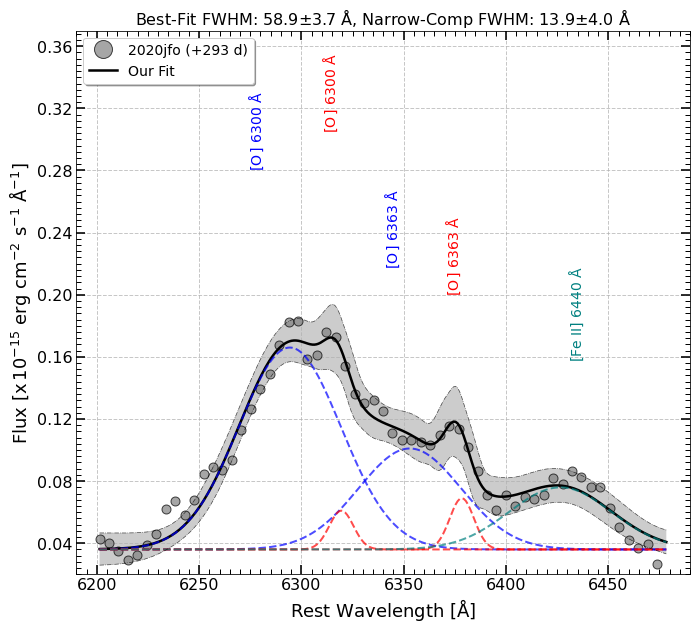

In [2]:
feature = 'OIDualV2'
wave_feature, wave_range, funcfit, guess, boundlow, boundhigh = dict_20jfo[feature]
wav, flux, fit_wav, opt, cov, err = fit_feature(wave_feature, func=funcfit)

opt1 = [round(opt[index], 3) for index in [0, 1, 10, 11]]
err1 = [round(err[index], 3) for index in [0, 1, 10, 11]]
opt2 = [round(opt[index], 3) for index in [2, 3, 10, 11]]
err2 = [round(err[index], 3) for index in [2, 3, 10, 11]]
opt3 = [round(opt[index], 3) for index in [4, 1, 9, 6, 11]]
err3 = [round(err[index], 3) for index in [4, 1, 9, 6, 11]]
opt4 = [round(opt[index], 3) for index in [5, 3, 9, 6, 11]]
err4 = [round(err[index], 3) for index in [5, 3, 9, 6, 11]]
opt5 = [round(opt[index], 3) for index in [7, 8, 10, 11]]
err5 = [round(err[index], 3) for index in [7, 8, 10, 11]]

print (opt1, err1)
print (opt2, err2)
print (opt3, err3)
print (opt4, err4)
print (opt5, err5)

oi6300 = calc_flux(opt1, err1, norm_factor)
oi6363 = calc_flux(opt2, err2, norm_factor)
oi6300_2 = calc_flux(opt3, err3, norm_factor, shifted=True)
oi6363_2 = calc_flux(opt4, err4, norm_factor, shifted=True)

print("-" * 40)
print("First Component")
print("[OI]-6300 = {0:.2e}+/-{1:.2e}".format(*oi6300))
print("[OI]-6363 = {0:.2e}+/-{1:.2e}".format(*oi6363))
print("[OI]-6300/[OI]-6363 = {0:.2f}".format(oi6300[0] / oi6363[0]))
print("-" * 40)
print("Second Component")
print("[OI]-6300 = {0:.2e}+/-{1:.2e}".format(*oi6300_2))
print("[OI]-6363 = {0:.2e}+/-{1:.2e}".format(*oi6363_2))
print("[OI]-6300/[OI]-6363 = {0:.2f}".format(oi6300_2[0] / oi6363_2[0]))
print("-" * 40)

fig = plt.figure(figsize=(11, 10))
ax = fig.add_subplot(111)

ax.plot(wav, flux, c='k', mfc='grey', mew=1, ls='', marker='o', ms=9, alpha=0.7, label='2020jfo (+293 d)')
ax.plot(fit_wav, funcfit(fit_wav, *opt), lw=2.5, ls='-', c='k', label='Our Fit')
ax.plot(fit_wav, gaussian(fit_wav, *opt1), lw=2, ls='--', alpha=0.7, c='b', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt2), lw=2, ls='--', alpha=0.7, c='b', label='_nolegend_')
ax.plot(fit_wav, gaussianshifted(fit_wav, *opt3), lw=2, ls='--', alpha=0.7, c='r', label='_nolegend_')
ax.plot(fit_wav, gaussianshifted(fit_wav, *opt4), lw=2, ls='--', alpha=0.7, c='r', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt5), lw=2, ls='--', alpha=0.7, c='teal', label='_nolegend_')

plot_confintervals(ax, opt, cov, fit_wav, fcolor='grey', components=feature)

# ax.set_yticklabels([])
ax.set_ylim(0.02, 0.37)
ax.set_xlim(6190, 6490)
ax.legend(markerscale=2, fontsize=14, frameon=True, fancybox=True, shadow=True, loc=2)
set_plotparams(ax, yticks=(0.04, 0.004), xticks=(50, 5), fs=16)

ax.set_xlabel(r'Rest Wavelength [$\rm \AA$]', fontsize=18)
ax.set_ylabel(r'Flux [$\rm x\,10^{-15}\ erg\ cm^{-2}\ s^{-1}\ \AA^{-1}$]', fontsize=18)
ax.set_title(r'Best-Fit FWHM: {0:.1f}$\pm${1:.1f} $\rm \AA$, Narrow-Comp FWHM: {2:.1f}$\pm${3:.1f} $\rm \AA$'.format(opt[-2] * 2.3546, err[-2] * 2.3546, opt[6] * 2.3546, err[6] * 2.3546), fontsize=16)

ax.text(0.28, 0.75, r"$\rm [O\,]\ 6300\ \AA$", fontsize=14, color='b', rotation=90, transform=ax.transAxes)
ax.text(0.5, 0.57, r"$\rm [O\,]\ 6363\ \AA$", fontsize=14, color='b', rotation=90, transform=ax.transAxes)
ax.text(0.4, 0.82, r"$\rm [O\,]\ 6300\ \AA$", fontsize=14, color='r', rotation=90, transform=ax.transAxes)
ax.text(0.6, 0.52, r"$\rm [O\,]\ 6363\ \AA$", fontsize=14, color='r', rotation=90, transform=ax.transAxes)
ax.text(0.8, 0.40, r"$\rm [Fe\ II]\ 6440\ \AA$", fontsize=14, color='teal', rotation=90, transform=ax.transAxes)

fig.savefig('PLOT_OIDualV2Fit.pdf', format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig)
# ------------------------------------------------------------------------------------------------------------------- #

### Halpha Single Fit

[0.792, 6565.075, 26.786, 0.049] [0.012, 0.496, 0.611, 0.008]
[0.099, 6640.0, 26.786, 0.049] [0.012, 4.905, 0.611, 0.008]
----------------------------------------
Halpha-6563 = 5.32e-14+/-1.46e-15
----------------------------------------


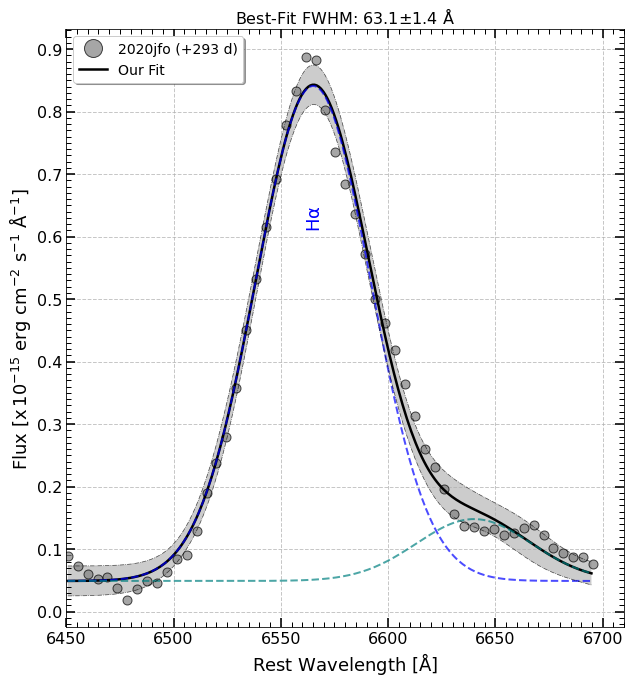

In [4]:
# ------------------------------------------------------------------------------------------------------------------- #
# Plotting The Fit To The Spectral Feature
# ------------------------------------------------------------------------------------------------------------------- #
feature = 'Halpha'
wave_feature, wave_range, funcfit, guess, boundlow, boundhigh = dict_20jfo[feature]
wav, flux, fit_wav, opt, cov, err = fit_feature(wave_feature, func=funcfit)

opt1 = [round(opt[index], 3) for index in [0, 1, 4, 5]]
err1 = [round(err[index], 3) for index in [0, 1, 4, 5]]
opt2 = [round(opt[index], 3) for index in [2, 3, 4, 5]]
err2 = [round(err[index], 3) for index in [2, 3, 4, 5]]

print (opt1, err1)
print (opt2, err2)

halpha = calc_flux(opt1, err1, norm_factor)

print("-" * 40)
print("Halpha-6563 = {0:.2e}+/-{1:.2e}".format(*halpha))
print("-" * 40)

fig = plt.figure(figsize=(10, 11))
ax = fig.add_subplot(111)

ax.plot(wav, flux, c='k', mfc='grey', mew=1, ls='', marker='o', ms=9, alpha=0.7, label='2020jfo (+293 d)')
ax.plot(fit_wav, funcfit(fit_wav, *opt), lw=2.5, ls='-', c='k', label='Our Fit')
ax.plot(fit_wav, gaussian(fit_wav, *opt1), lw=2, ls='--', alpha=0.7, c='b', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt2), lw=2, ls='--', alpha=0.7, c='teal', label='_nolegend_')

plot_confintervals(ax, opt, cov, fit_wav, fcolor='grey', components=2)

# ax.set_yticklabels([])
# ax.set_ylim(0.02, 0.4)
ax.set_xlim(6450, 6710)
ax.legend(markerscale=2, fontsize=14, frameon=True, fancybox=True, shadow=True, loc=2)
set_plotparams(ax, yticks=(0.1, 0.01), xticks=(50, 5), fs=16)

ax.set_xlabel(r'Rest Wavelength [$\rm \AA$]', fontsize=18)
ax.set_ylabel(r'Flux [$\rm x\,10^{-15}\ erg\ cm^{-2}\ s^{-1}\ \AA^{-1}$]', fontsize=18)
ax.set_title(r'Best-Fit FWHM: {0:.1f}$\pm${1:.1f} $\rm \AA$'.format(opt[-2] * 2.3546, err[-2] * 2.3546), fontsize=16)
ax.text(0.43, 0.67, r"$\rm H\alpha$", fontsize=18, color='b', rotation=90, transform=ax.transAxes)

fig.savefig('PLOT_HalphaSingleFit.pdf', format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig)
# ------------------------------------------------------------------------------------------------------------------- #

### Halpha Dual Component Fit

[0.744, 6559.247, 22.34, 0.052] [0.015, 0.814, 0.584, 0.005]
[0.244, 6559.247, 0.006, 22.34, 0.052] [0.026, 0.814, 0.0, 0.584, 0.005]
[0.068, 6664.707, 22.34, 0.052] [0.008, 3.911, 0.584, 0.005]
----------------------------------------
First Component
Halpha-6563 = 4.17e-14+/-1.38e-15
----------------------------------------
Dual Component
Halpha-6563 = 1.37e-14+/-1.50e-15
----------------------------------------


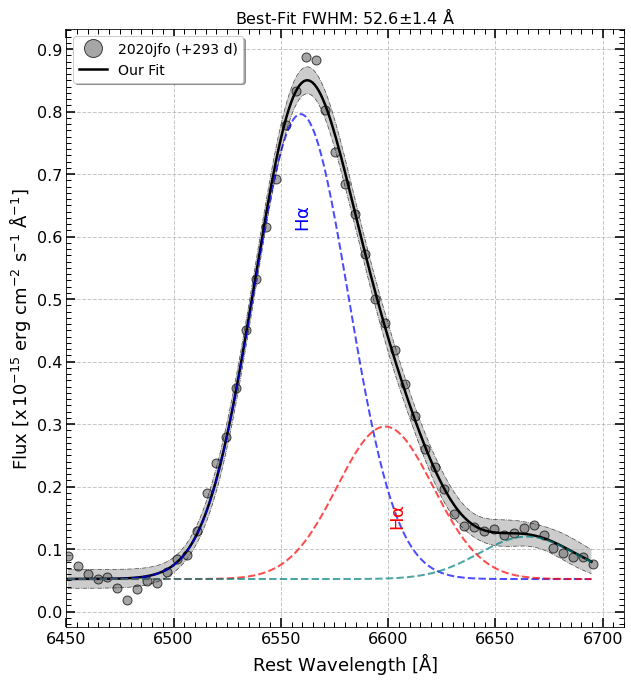

In [8]:
# ------------------------------------------------------------------------------------------------------------------- #
# Plotting The Fit To The Spectral Feature
# ------------------------------------------------------------------------------------------------------------------- #
feature = 'HalphaDual'
wave_feature, wave_range, funcfit, guess, boundlow, boundhigh = dict_20jfo[feature]
wav, flux, fit_wav, opt, cov, err = fit_feature(wave_feature, func=funcfit)

opt1 = [round(opt[index], 3) for index in [0, 1, 6, 7]]
err1 = [round(err[index], 3) for index in [0, 1, 6, 7]]
opt2 = [round(opt[index], 3) for index in [2, 1, 5, 6, 7]]
err2 = [round(err[index], 3) for index in [2, 1, 5, 6, 7]]
opt3 = [round(opt[index], 3) for index in [3, 4, 6, 7]]
err3 = [round(err[index], 3) for index in [3, 4, 6, 7]]

print (opt1, err1)
print (opt2, err2)
print (opt3, err3)

halpha = calc_flux(opt1, err1, norm_factor)
halpha_2 = calc_flux(opt2, err2, norm_factor, shifted=True)

print("-" * 40)
print("First Component")
print("Halpha-6563 = {0:.2e}+/-{1:.2e}".format(*halpha))
print("-" * 40)
print("Dual Component")
print("Halpha-6563 = {0:.2e}+/-{1:.2e}".format(*halpha_2))
print("-" * 40)


fig = plt.figure(figsize=(10, 11))
ax = fig.add_subplot(111)

ax.plot(wav, flux, c='k', mfc='grey', mew=1, ls='', marker='o', ms=9, alpha=0.7, label='2020jfo (+293 d)')
ax.plot(fit_wav, funcfit(fit_wav, *opt), lw=2.5, ls='-', c='k', label='Our Fit')
ax.plot(fit_wav, gaussian(fit_wav, *opt1), lw=2, ls='--', alpha=0.7, c='b', label='_nolegend_')
ax.plot(fit_wav, gaussianshifted(fit_wav, *opt2), lw=2, ls='--', alpha=0.7, c='r', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt3), lw=2, ls='--', alpha=0.7, c='teal', label='_nolegend_')

plot_confintervals(ax, opt, cov, fit_wav, fcolor='grey', components=feature)

# ax.set_yticklabels([])
# ax.set_ylim(0.02, 0.4)
ax.set_xlim(6450, 6710)
ax.legend(markerscale=2, fontsize=14, frameon=True, fancybox=True, shadow=True, loc=2)
set_plotparams(ax, yticks=(0.1, 0.01), xticks=(50, 5), fs=16)

ax.set_xlabel(r'Rest Wavelength [$\rm \AA$]', fontsize=18)
ax.set_ylabel(r'Flux [$\rm x\,10^{-15}\ erg\ cm^{-2}\ s^{-1}\ \AA^{-1}$]', fontsize=18)
ax.set_title(r'Best-Fit FWHM: {0:.1f}$\pm${1:.1f} $\rm \AA$'.format(opt[-2] * 2.3546, err[-2] * 2.3546), fontsize=16)

ax.text(0.41, 0.67, r"$\rm H\alpha$", fontsize=18, color='b', rotation=90, transform=ax.transAxes)
ax.text(0.58, 0.17, r"$\rm H\alpha$", fontsize=18, color='r', rotation=90, transform=ax.transAxes)

fig.savefig('PLOT_HalphaDualFit.pdf', format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig)
# ------------------------------------------------------------------------------------------------------------------- #

### OI 6300/6364 Single Component Fit

[0.21, 6297.045, 27.77, 0.055] [0.009, 1.76, 1.825, 0.007]
[0.092, 6360.858, 27.77, 0.055] [0.011, 5.718, 1.825, 0.007]
[0.045, 6430.0, 27.77, 0.055] [0.009, 8.1, 1.825, 0.007]
----------------------------------------
[OI]-6300 = 1.46e-14+/-1.15e-15
[OI]-6363 = 6.40e-15+/-8.74e-16
[OI]-6300/[OI]-6363 = 2.28
----------------------------------------


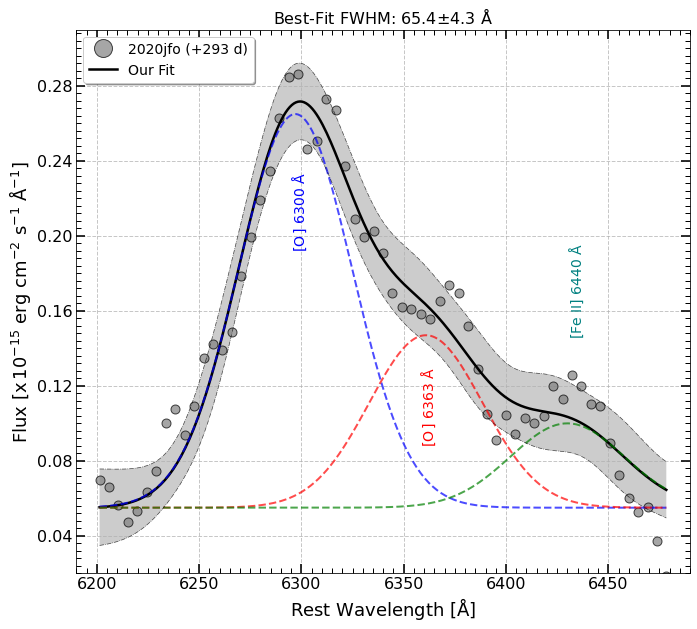

In [15]:
# ------------------------------------------------------------------------------------------------------------------- #
# Plotting The Fit To The Spectral Feature
# ------------------------------------------------------------------------------------------------------------------- #
feature = 'OI'
wave_feature, wave_range, funcfit, guess, boundlow, boundhigh = dict_20jfo[feature]
wav, flux, fit_wav, opt, cov, err = fit_feature(wave_feature, func=funcfit)

opt1 = [round(opt[index], 3) for index in [0, 1, 6, 7]]
err1 = [round(err[index], 3) for index in [0, 1, 6, 7]]
opt2 = [round(opt[index], 3) for index in [2, 3, 6, 7]]
err2 = [round(err[index], 3) for index in [2, 3, 6, 7]]
opt3 = [round(opt[index], 3) for index in [4, 5, 6, 7]]
err3 = [round(err[index], 3) for index in [4, 5, 6, 7]]

print (opt1, err1)
print (opt2, err2)
print (opt3, err3)

oi6300 = calc_flux(opt1, err1, norm_factor)
oi6363 = calc_flux(opt2, err2, norm_factor)

print("-" * 40)
print("[OI]-6300 = {0:.2e}+/-{1:.2e}".format(*oi6300))
print("[OI]-6363 = {0:.2e}+/-{1:.2e}".format(*oi6363))
print("[OI]-6300/[OI]-6363 = {0:.2f}".format(oi6300[0] / oi6363[0]))
print("-" * 40)

fig = plt.figure(figsize=(11, 10))
ax = fig.add_subplot(111)

ax.plot(wav, flux, c='k', mfc='grey', mew=1, ls='', marker='o', ms=9, alpha=0.7, label='2020jfo (+293 d)')
ax.plot(fit_wav, funcfit(fit_wav, *opt), lw=2.5, ls='-', c='k', label='Our Fit')
ax.plot(fit_wav, gaussian(fit_wav, *opt1), lw=2, ls='--', alpha=0.7, c='b', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt2), lw=2, ls='--', alpha=0.7, c='r', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt3), lw=2, ls='--', alpha=0.7, c='g', label='_nolegend_')

plot_confintervals(ax, opt, cov, fit_wav, fcolor='grey', components=3)

# ax.set_yticklabels([])
ax.set_xlim(6190, 6490)
ax.set_ylim(0.02, 0.31)
ax.legend(markerscale=2, fontsize=14, frameon=True, fancybox=True, shadow=True, loc=2)
set_plotparams(ax, yticks=(0.04, 0.004), xticks=(50, 5), fs=16)

ax.set_xlabel(r'Rest Wavelength [$\rm \AA$]', fontsize=18)
ax.set_ylabel(r'Flux [$\rm x\,10^{-15}\ erg\ cm^{-2}\ s^{-1}\ \AA^{-1}$]', fontsize=18)
ax.set_title(r'Best-Fit FWHM: {0:.1f}$\pm${1:.1f} $\rm \AA$'.format(opt[-2] * 2.3546, err[-2] * 2.3546), fontsize=16)

ax.text(0.35, 0.6, r"$\rm [O\,]\ 6300\ \AA$", fontsize=14, color='b', rotation=90, transform=ax.transAxes)
ax.text(0.56, 0.24, r"$\rm [O\,]\ 6363\ \AA$", fontsize=14, color='r', rotation=90, transform=ax.transAxes)
ax.text(0.8, 0.44, r"$\rm [Fe\ II]\ 6440\ \AA$", fontsize=14, color='teal', rotation=90, transform=ax.transAxes)

fig.savefig('PLOT_OISingleFit.pdf', format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig)
# ------------------------------------------------------------------------------------------------------------------- #

### OI 6300/6364 Dual Component Fit

[0.117, 6280.0, 20.224, 0.059] [0.036, 8.36, 4.379, 0.007]
[0.051, 6343.0, 20.224, 0.059] [0.085, 14.731, 4.379, 0.007]
[0.154, 6280.0, 0.005, 20.224, 0.059] [0.051, 8.36, 0.001, 4.379, 0.007]
[0.078, 6343.0, 0.005, 20.224, 0.059] [0.041, 14.731, 0.001, 4.379, 0.007]
[0.053, 6430.421, 20.224, 0.059] [0.009, 4.694, 4.379, 0.007]
----------------------------------------
First Component
[OI]-6300 = 5.93e-15+/-2.23e-15
[OI]-6363 = 2.59e-15+/-4.35e-15
[OI]-6300/[OI]-6363 = 2.29
----------------------------------------
Second Component
[OI]-6300 = 7.81e-15+/-3.09e-15
[OI]-6363 = 3.95e-15+/-2.25e-15
[OI]-6300/[OI]-6363 = 1.97
----------------------------------------


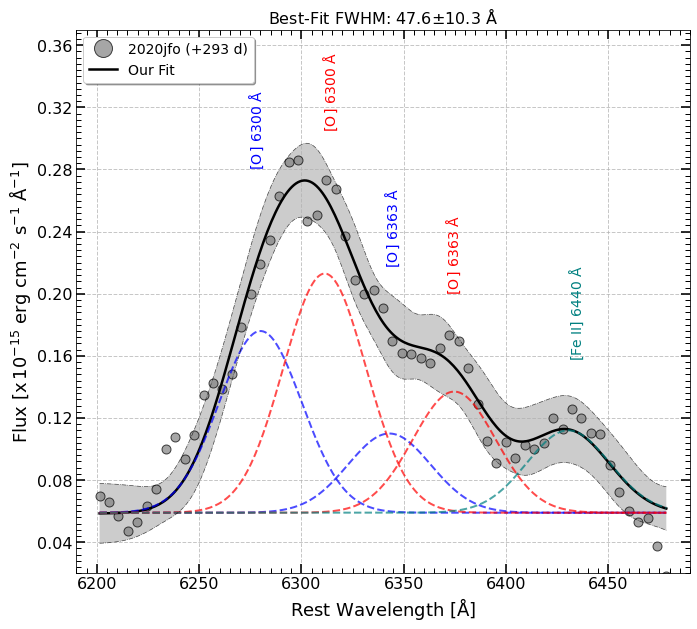

In [14]:
feature = 'OIDual'
wave_feature, wave_range, funcfit, guess, boundlow, boundhigh = dict_20jfo[feature]
wav, flux, fit_wav, opt, cov, err = fit_feature(wave_feature, func=funcfit)

opt1 = [round(opt[index], 3) for index in [0, 1, 9, 10]]
err1 = [round(err[index], 3) for index in [0, 1, 9, 10]]
opt2 = [round(opt[index], 3) for index in [2, 3, 9, 10]]
err2 = [round(err[index], 3) for index in [2, 3, 9, 10]]
opt3 = [round(opt[index], 3) for index in [4, 1, 8, 9, 10]]
err3 = [round(err[index], 3) for index in [4, 1, 8, 9, 10]]
opt4 = [round(opt[index], 3) for index in [5, 3, 8, 9, 10]]
err4 = [round(err[index], 3) for index in [5, 3, 8, 9, 10]]
opt5 = [round(opt[index], 3) for index in [6, 7, 9, 10]]
err5 = [round(err[index], 3) for index in [6, 7, 9, 10]]

print (opt1, err1)
print (opt2, err2)
print (opt3, err3)
print (opt4, err4)
print (opt5, err5)

oi6300 = calc_flux(opt1, err1, norm_factor)
oi6363 = calc_flux(opt2, err2, norm_factor)
oi6300_2 = calc_flux(opt3, err3, norm_factor, shifted=True)
oi6363_2 = calc_flux(opt4, err4, norm_factor, shifted=True)

print("-" * 40)
print("First Component")
print("[OI]-6300 = {0:.2e}+/-{1:.2e}".format(*oi6300))
print("[OI]-6363 = {0:.2e}+/-{1:.2e}".format(*oi6363))
print("[OI]-6300/[OI]-6363 = {0:.2f}".format(oi6300[0] / oi6363[0]))
print("-" * 40)
print("Second Component")
print("[OI]-6300 = {0:.2e}+/-{1:.2e}".format(*oi6300_2))
print("[OI]-6363 = {0:.2e}+/-{1:.2e}".format(*oi6363_2))
print("[OI]-6300/[OI]-6363 = {0:.2f}".format(oi6300_2[0] / oi6363_2[0]))
print("-" * 40)

fig = plt.figure(figsize=(11, 10))
ax = fig.add_subplot(111)

ax.plot(wav, flux, c='k', mfc='grey', mew=1, ls='', marker='o', ms=9, alpha=0.7, label='2020jfo (+293 d)')
ax.plot(fit_wav, funcfit(fit_wav, *opt), lw=2.5, ls='-', c='k', label='Our Fit')
ax.plot(fit_wav, gaussian(fit_wav, *opt1), lw=2, ls='--', alpha=0.7, c='b', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt2), lw=2, ls='--', alpha=0.7, c='b', label='_nolegend_')
ax.plot(fit_wav, gaussianshifted(fit_wav, *opt3), lw=2, ls='--', alpha=0.7, c='r', label='_nolegend_')
ax.plot(fit_wav, gaussianshifted(fit_wav, *opt4), lw=2, ls='--', alpha=0.7, c='r', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt5), lw=2, ls='--', alpha=0.7, c='teal', label='_nolegend_')

plot_confintervals(ax, opt, cov, fit_wav, fcolor='grey', components=feature)

# ax.set_yticklabels([])
ax.set_ylim(0.02, 0.37)
ax.set_xlim(6190, 6490)
ax.legend(markerscale=2, fontsize=14, frameon=True, fancybox=True, shadow=True, loc=2)
set_plotparams(ax, yticks=(0.04, 0.004), xticks=(50, 5), fs=16)

ax.set_xlabel(r'Rest Wavelength [$\rm \AA$]', fontsize=18)
ax.set_ylabel(r'Flux [$\rm x\,10^{-15}\ erg\ cm^{-2}\ s^{-1}\ \AA^{-1}$]', fontsize=18)
ax.set_title(r'Best-Fit FWHM: {0:.1f}$\pm${1:.1f} $\rm \AA$'.format(opt[-2] * 2.3546, err[-2] * 2.3546), fontsize=16)

ax.text(0.28, 0.75, r"$\rm [O\,]\ 6300\ \AA$", fontsize=14, color='b', rotation=90, transform=ax.transAxes)
ax.text(0.5, 0.57, r"$\rm [O\,]\ 6363\ \AA$", fontsize=14, color='b', rotation=90, transform=ax.transAxes)
ax.text(0.4, 0.82, r"$\rm [O\,]\ 6300\ \AA$", fontsize=14, color='r', rotation=90, transform=ax.transAxes)
ax.text(0.6, 0.52, r"$\rm [O\,]\ 6363\ \AA$", fontsize=14, color='r', rotation=90, transform=ax.transAxes)
ax.text(0.8, 0.40, r"$\rm [Fe\ II]\ 6440\ \AA$", fontsize=14, color='teal', rotation=90, transform=ax.transAxes)

fig.savefig('PLOT_OIDualFit.pdf', format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig)
# ------------------------------------------------------------------------------------------------------------------- #